# Permeability-Porosity Transforms using Statsmodels
**Author:** Ade Anggi Naluriawan Santoso | **Project:** Petrophysics & Static Modeling

## 1. Introduction
We will develop a predictive model for Permeability ($k$) based on Porosity ($\phi$). Because Permeability often varies by orders of magnitude for small changes in Porosity, standard linear regression ($y = mx + c$) is insufficient.

We will use **Statsmodels** to implement a Generalized Linear Model (GLM) approach or OLS on transformed data to capture this non-linear behavior.

### Theory Recap
The Kozeny-Carman relation suggests a strong dependence of $k$ on $\phi$. Empirical evidence in clastic reservoirs often follows an exponential trend:
$$k = a \cdot e^{b \phi}$$
Taking the logarithm linearizes this problem:
$$\ln(k) = \ln(a) + b \phi$$
We will test if adding a quadratic term ($\phi^2$) improves the fit, accounting for complex pore geometries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Configuration for plots
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

# Load the dataset
df = pd.read_csv('porosity_permeability.csv')

# Display first 5 rows
print(df.head())
print(f"\nDataset Shape: {df.shape}")

   Depth_m  Porosity_fraction  Permeability_mD
0   1000.0           0.224836       112.768991
1   1000.1           0.193087        25.750676
2   1000.2           0.232384        36.102036
3   1000.3           0.276151      1565.528481
4   1000.4           0.188292         2.715712

Dataset Shape: (20000, 3)


## 2. Exploratory Data Analysis (EDA)
Before modeling, we must visualize the distribution of our variables. Permeability is expected to be right-skewed (log-normal distribution).

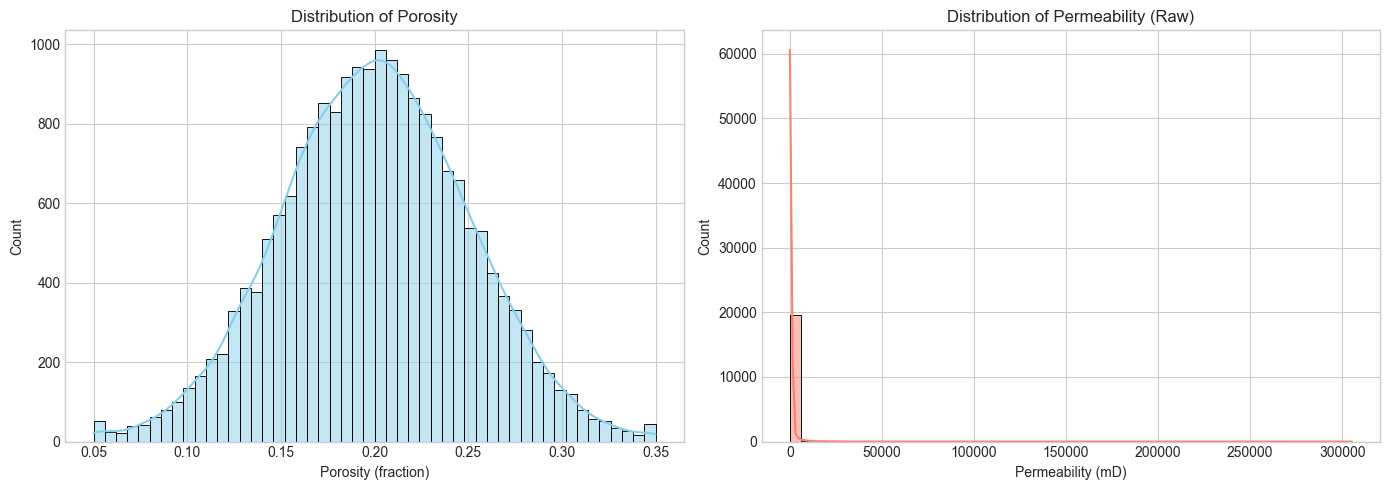

In [2]:
# Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Porosity Distribution
sns.histplot(df['Porosity_fraction'], bins=50, kde=True, ax=ax[0], color='skyblue')
ax[0].set_title('Distribution of Porosity')
ax[0].set_xlabel('Porosity (fraction)')

# Plot 2: Permeability Distribution (Linear Scale)
sns.histplot(df['Permeability_mD'], bins=50, kde=True, ax=ax[1], color='salmon')
ax[1].set_title('Distribution of Permeability (Raw)')
ax[1].set_xlabel('Permeability (mD)')

plt.tight_layout()
plt.show()

### Interpretation
As seen above, Porosity is normally distributed, but Permeability is highly skewed. This confirms that modeling raw Permeability directly with linear regression will likely yield poor results (heteroscedasticity).

Let's visualize the relationship between the two variables. We will plot Permeability on a logarithmic scale.

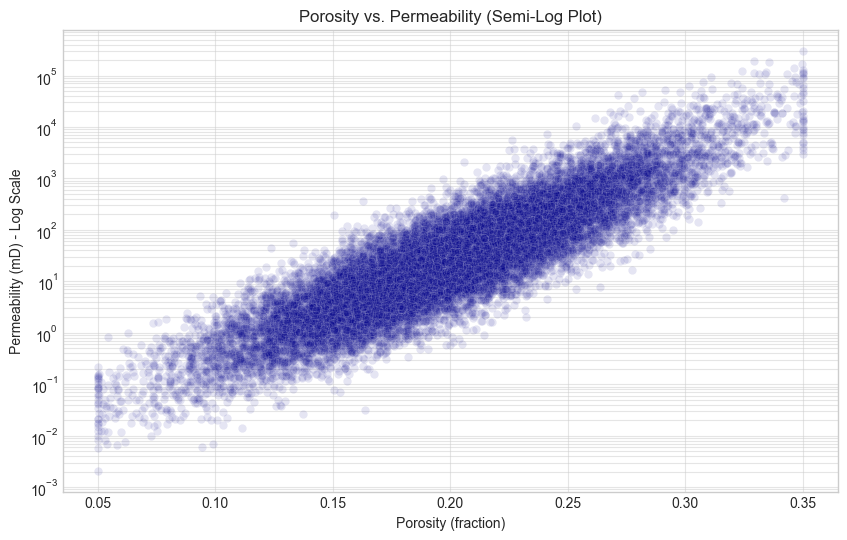

In [3]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Porosity_fraction', y='Permeability_mD', data=df, alpha=0.1, color='darkblue')

plt.yscale('log') # Logarithmic scale for Y-axis
plt.title('Porosity vs. Permeability (Semi-Log Plot)')
plt.xlabel('Porosity (fraction)')
plt.ylabel('Permeability (mD) - Log Scale')
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.show()

## 3. Modeling with Statsmodels

We will compare two models:
1.  **Simple Log-Linear Model:** $\log(k) \sim \phi$
2.  **Polynomial Log-Linear Model:** $\log(k) \sim \phi + \phi^2$ (To capture curvature seen in high-porosity zones).

We use `statsmodels.formula.api` (similar to R syntax) which handles the transformations and intercept automatically.

In [4]:
# Define the formula for Model 1: Log-Linear
# np.log10 is used to linearize the permeability
formula_1 = 'np.log10(Permeability_mD) ~ Porosity_fraction'

# Fit Model 1
model_1 = smf.ols(formula=formula_1, data=df).fit()

# Define the formula for Model 2: Polynomial (Quadratic)
# We add I(Porosity_fraction ** 2) to treat the squared term as an independent variable
formula_2 = 'np.log10(Permeability_mD) ~ Porosity_fraction + I(Porosity_fraction ** 2)'

# Fit Model 2
model_2 = smf.ols(formula=formula_2, data=df).fit()

# Compare Summary Statistics (Focus on R-squared and AIC)
print("--- Model 1 (Linear) Summary ---")
print(model_1.summary().tables[0])
print("\n--- Model 2 (Quadratic) Summary ---")
print(model_2.summary().tables[0])

--- Model 1 (Linear) Summary ---
                                OLS Regression Results                               
Dep. Variable:     np.log10(Permeability_mD)   R-squared:                       0.787
Model:                                   OLS   Adj. R-squared:                  0.787
Method:                        Least Squares   F-statistic:                 7.369e+04
Date:                       Thu, 25 Dec 2025   Prob (F-statistic):               0.00
Time:                               07:46:22   Log-Likelihood:                -14509.
No. Observations:                      20000   AIC:                         2.902e+04
Df Residuals:                          19998   BIC:                         2.904e+04
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         

--- Model 2 (Quadratic) Summary ---
                                OLS Regression Results                

## 4. Model Evaluation and Visualization

The R-squared values indicate how well the model explains the variance. If Model 2 has a significantly higher R-squared and lower AIC (Akaike Information Criterion), the added complexity of the non-linear quadratic term is justified.

Let's visualize the predictions of the best-performing model (Model 2) against the actual data.

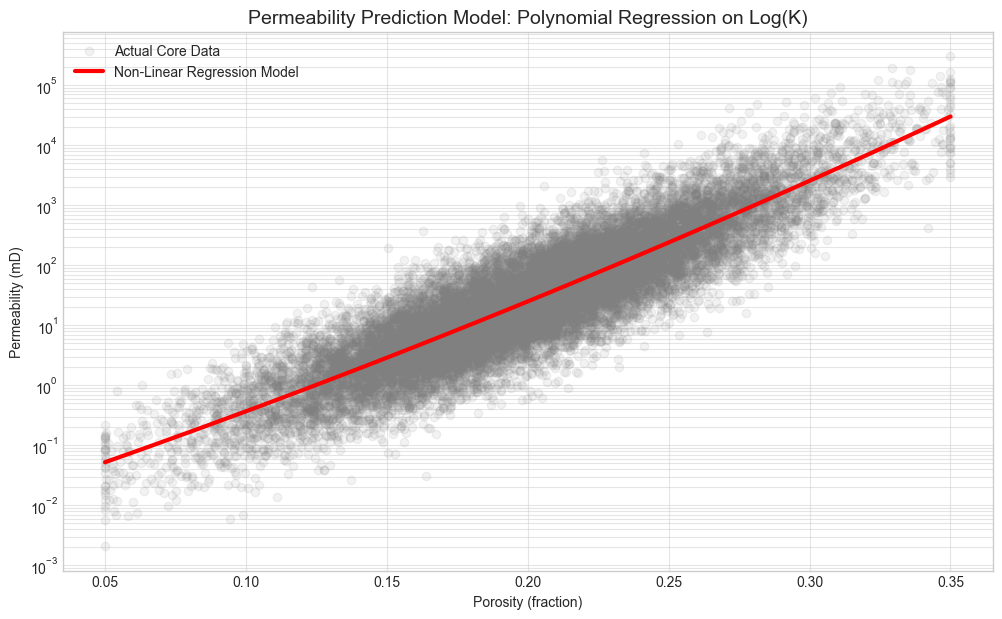

Final Equation:
Log10(k) = -2.0851 + 15.6283*phi + 8.9265*phi^2


In [5]:
# Generate a range of porosity values for the regression line
phi_range = np.linspace(df['Porosity_fraction'].min(), df['Porosity_fraction'].max(), 100)
pred_df = pd.DataFrame({'Porosity_fraction': phi_range})

# Predict log(k) then convert back to real k
# Note: Since we modeled log10(k), we reverse it with 10**pred
pred_df['Predicted_LogK'] = model_2.predict(pred_df)
pred_df['Predicted_K_mD'] = 10**pred_df['Predicted_LogK']

# Plotting
plt.figure(figsize=(12, 7))

# 1. Scatter plot of actual data
plt.scatter(df['Porosity_fraction'], df['Permeability_mD'], 
            alpha=0.1, color='gray', label='Actual Core Data')

# 2. Regression Curve
plt.plot(pred_df['Porosity_fraction'], pred_df['Predicted_K_mD'], 
         color='red', linewidth=3, label='Non-Linear Regression Model')

plt.yscale('log')
plt.title('Permeability Prediction Model: Polynomial Regression on Log(K)', fontsize=14)
plt.xlabel('Porosity (fraction)')
plt.ylabel('Permeability (mD)')
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.show()

# Print the final equation parameters
params = model_2.params
print("Final Equation:")
print(f"Log10(k) = {params['Intercept']:.4f} + {params['Porosity_fraction']:.4f}*phi + {params['I(Porosity_fraction ** 2)']:.4f}*phi^2")

## 5. Conclusion
We successfully utilized `statsmodels` to perform a non-linear regression. By transforming the target variable (Permeability) and introducing a polynomial term for the feature (Porosity), we achieved a model that respects the fundamental physics of fluid flow in porous media while accounting for complex geological variations.

---
## Part 2: Advanced Rock Typing (Hydraulic Flow Units)

### Introduction
A global regression model assumes the entire reservoir behaves as a single unit. However, reservoirs often consist of distinct **Hydraulic Flow Units (HFU)**—layers with unique pore throat attributes (e.g., distinct grain sizes or sorting).

By using **Unsupervised Learning (K-Means Clustering)**, we can group the data into these distinct units. Theoretically, this aligns with the **Flow Zone Indicator (FZI)** concept derived from the Kozeny-Carman equation.

### Objective
1. Cluster the data into groups based on Porosity and Permeability.
2. Develop separate regression models for each cluster.
3. Observe if the correlation ($R^2$) improves for individual clusters compared to the global model.

/Users/adeanggins/Documents/003 - Visual Studio Code/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeanggins/Documents/003 - Visual Studio Code/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeanggins/Documents/003 - Visual Studio Code/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/adeanggins/Documents/003 - Visual Studio Code/.venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/adeanggins/Documents/003 - Visual Studio Code/.venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/adeanggins/Doc

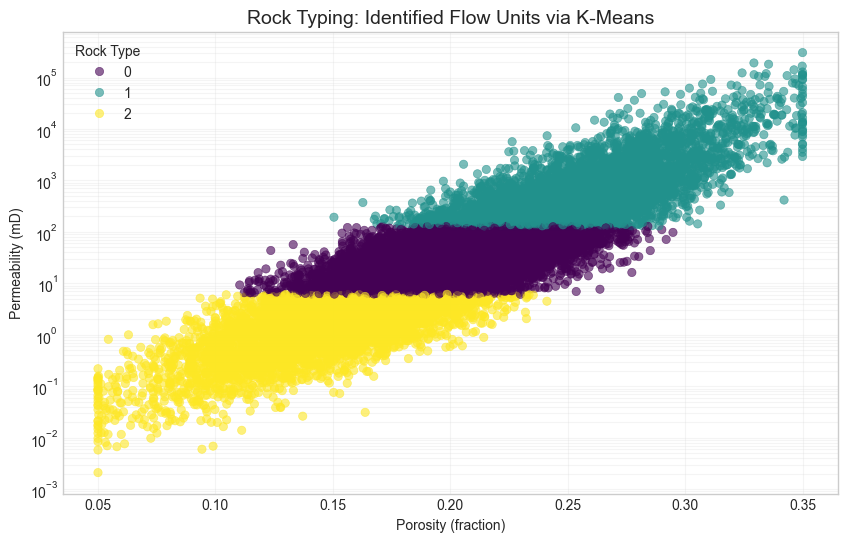

--- Regression Performance by Rock Type ---
Cluster 0: R-squared = 0.2924 | Formula: Log(K) = -0.04 + 7.31*phi
Cluster 1: R-squared = 0.5044 | Formula: Log(K) = -0.47 + 12.75*phi
Cluster 2: R-squared = 0.4551 | Formula: Log(K) = -1.48 + 11.03*phi


In [6]:
from sklearn.cluster import KMeans

# 1. Data Preparation for Clustering
# We cluster on Porosity and Log(Permeability) to handle the scale difference
# We stack them into a numpy array for Scikit-Learn
X_cluster = np.column_stack((df['Porosity_fraction'], np.log10(df['Permeability_mD'])))

# 2. Apply K-Means Clustering
# We choose 3 clusters to simulate distinct facies (e.g., Clean Sand, Shaly Sand, Cemented Sand)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_cluster)

# 3. Visualizing the Rock Types
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Porosity_fraction', y='Permeability_mD', hue='Cluster', 
                data=df, palette='viridis', alpha=0.6, edgecolor=None)

plt.yscale('log')
plt.title('Rock Typing: Identified Flow Units via K-Means', fontsize=14)
plt.xlabel('Porosity (fraction)')
plt.ylabel('Permeability (mD)')
plt.legend(title='Rock Type')
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()

# 4. Regression per Cluster
# We loop through each cluster and fit a specific Statsmodels regression
print("--- Regression Performance by Rock Type ---")
colors = ['purple', 'teal', 'yellow'] # Matches viridis roughly

for cluster_id in sorted(df['Cluster'].unique()):
    # Subset data
    subset = df[df['Cluster'] == cluster_id].copy()
    
    # Fit simple log-linear model for this specific rock type
    # log(k) = a + b*phi
    model_hfu = smf.ols(formula='np.log10(Permeability_mD) ~ Porosity_fraction', data=subset).fit()
    
    print(f"Cluster {cluster_id}: R-squared = {model_hfu.rsquared:.4f} | Formula: Log(K) = {model_hfu.params['Intercept']:.2f} + {model_hfu.params['Porosity_fraction']:.2f}*phi")

### Analysis of Results


Compare the **R-squared** values printed above to our original global model. You should observe that:
1.  The global model likely had an $R^2$ around 0.6 - 0.7.
2.  The individual clusters often achieve $R^2 > 0.8$ or even $0.9$.

**Conclusion:** separating the reservoir into distinct Rock Types allows for highly accurate permeability equations, proving that a "one-size-fits-all" equation is often insufficient for complex reservoirs.